## import

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

sys.path.append("../Lib")
from Mueller import Mueller
from flow import BG_RealNVP
from mcmc import  MetropolisGauss
from plot import plot_forward_backward_2d

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
params = Mueller.params_default.copy()
params['k'] = 0.1
params['dim'] = 2
mueller = Mueller(params=params)

In [5]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4), orientation='vertical'):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    return cbar

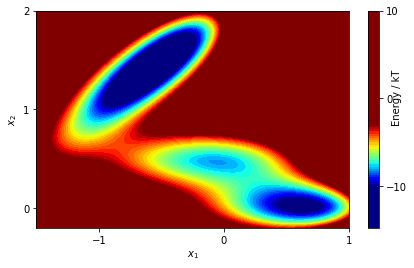

In [6]:
plot_potential(labels=True, cbar=True)

In [7]:
nsteps = 100000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

In [8]:
x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

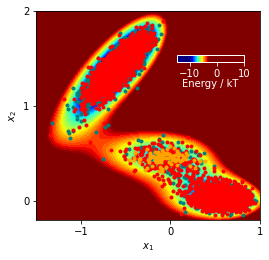

In [9]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/mueller/potential_horizontal.pdf', bbox_inches='tight', transparent=True)

In [10]:
x_brute = np.vstack([traj_left, traj_right])

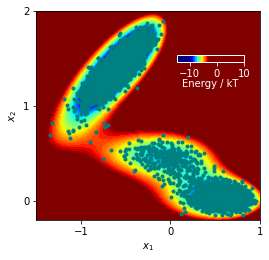

In [11]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(x_brute[:, 0],x_brute[:, 1], color='teal', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/mueller/potential_horizontal.pdf', bbox_inches='tight', transparent=True)

In [12]:
x_brute.shape

(20002, 2)

## BG

#### ML

In [13]:
model_BG=BG_RealNVP(mueller,dim=mueller.dim)

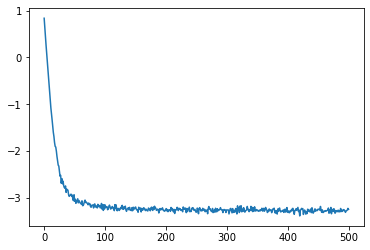

In [14]:
loss=model_BG.train_ML(x_brute,iter=500,lr=1e-4,batch_size=2048)
plt.plot(loss)

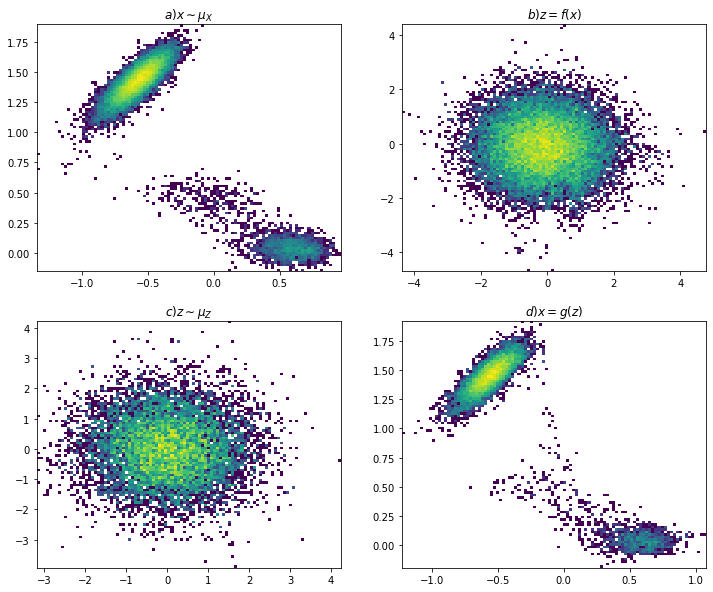

In [15]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(x_brute))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$b) z = f(x)$')

# sampling from gaussian and transform to x
z, x, _ = model_BG.sample(10000)

#plot gaussian
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$c) z \sim \mu_Z$')

# plot x transformed from gaussian
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$d) x = g(z)$')

plt.show()

In [16]:
model_BG=BG_RealNVP(mueller,dim=mueller.dim)

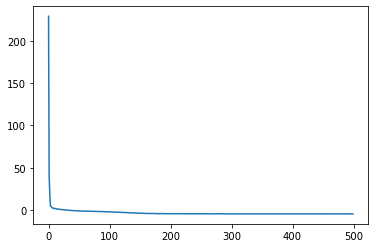

In [17]:
loss=model_BG.train_mix(x_brute,iter=500,lr=1e-4,batch_size=2048,w_kl=0.2, w_ml=0.8)
plt.plot(loss)

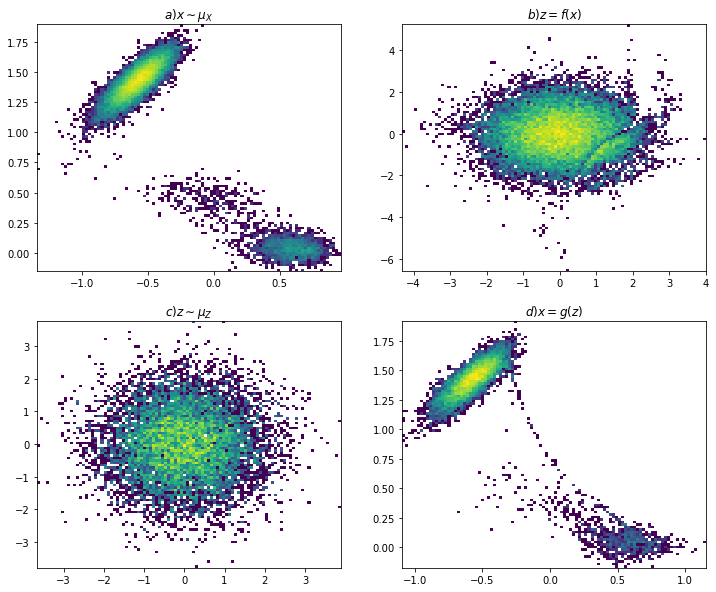

In [21]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(x_brute))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$b) z = f(x)$')

# sampling from gaussian and transform to x
z, x, _ = model_BG.sample(10000)

#plot gaussian
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$c) z \sim \mu_Z$')

# plot x transformed from gaussian
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$d) x = g(z)$')

plt.show()

In [23]:
model_BG=BG_RealNVP(mueller,dim=mueller.dim)

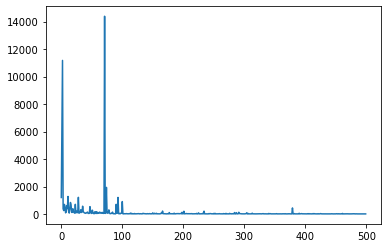

In [24]:
loss=model_BG.train_mix(x_brute,iter=500,lr=1e-5,batch_size=2048,w_kl=0.2, w_ml=0.8)
plt.plot(loss)

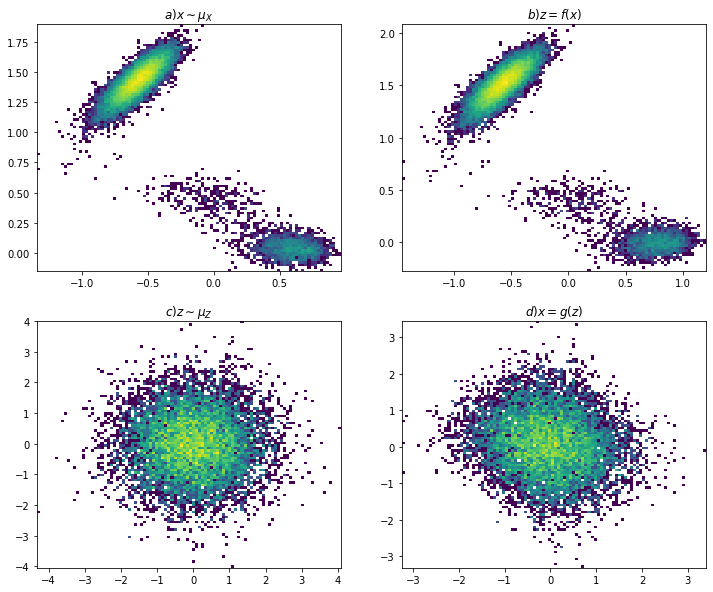

In [27]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(x_brute))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$b) z = f(x)$')

# sampling from gaussian and transform to x
z, x, _ = model_BG.sample(10000)

#plot gaussian
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$c) z \sim \mu_Z$')

# plot x transformed from gaussian
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$d) x = g(z)$')

plt.show()

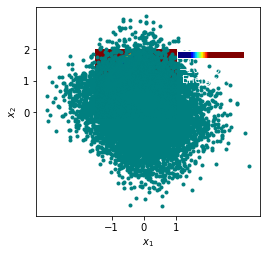

In [26]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(x[:, 0],x[:, 1], color='teal', linewidth=0, marker='.')

In [19]:
z, x, _ = model_BG.sample(10000)

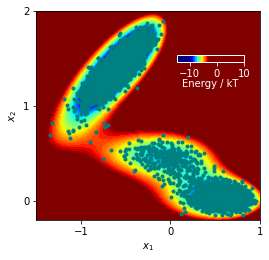

In [20]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(x_brute[:, 0],x_brute[:, 1], color='teal', linewidth=0, marker='.')

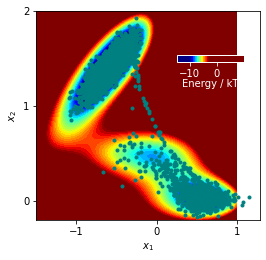

In [22]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(x[:, 0],x[:, 1], color='teal', linewidth=0, marker='.')